# Start

In [443]:
index = 2
K = 2
alpha = 0.75
c = 60
if_cosider_overhead_cost = 1

In [444]:
import gurobipy
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [445]:
data_path = "/Users/jiaxinli/Downloads/project"
city_small = pd.read_csv(data_path + "/cities_small.csv")
package_small = pd.read_csv(data_path + "/packages_small.csv")

In [446]:
# Construct the package number matrix F
N = len(city_small)
package_mat = np.zeros(shape = (N, N))
for i in range(len(package_small)):
    package_mat[package_small.iloc[i, 0]][package_small.iloc[i, 1]] = package_small.iloc[i, 2]

In [447]:
# Create a function to calculate distances
def calculate_distances(df, x = "lat", y = "lon"):
    # Extract the coordinates as a 2D numpy array
    coordinates = df[[x, y]].values

    # Use pdist to calculate pairwise distances
    distances = pdist(coordinates)  # This gives condensed distance matrix

    # Convert the condensed distance matrix to a square distance matrix
    square_distances = squareform(distances)

    # Create a DataFrame to display the distances
    distance_df = pd.DataFrame(square_distances, index=df.index, columns=df.index)

    return distance_df

# Calculate distances
distance_matrix = calculate_distances(city_small)


In [448]:
D_mat = np.ones(shape = (N, N))
for i in range(N):
    D_mat[i][i] = 0

# Q2 Model

In [ ]:
MODEL = gurobipy.Model()

# Add the network construction variables
c_Vars = [[0 for i in range(N)] for j in range(N)]
for i in range(N):
    for j in range(N):
        curVar = MODEL.addVar(vtype = gurobipy.GRB.BINARY,
                              name = "c" + str(i) + str(j))
        c_Vars[i][j] = curVar

# Add the y variable
y_Vars = [[0 for i in range(N)] for j in range(N)]
for i in range(N):
    for j in range(N):
        curVar = MODEL.addVar(vtype = gurobipy.GRB.CONTINUOUS,
                              name = "y" + str(i) + str(j))
        y_Vars[i][j] = curVar

MODEL.update()

# Create a linear expression for the objective
objExpr = gurobipy.LinExpr()
for i in range(N):
    for j in range(N):
        f_ij = package_mat[i][j]
        for k in range(N):
            cur_cVar = c_Vars[i][k]
            d_ik = distance_matrix[i][k]
            objExpr += f_ij * d_ik * cur_cVar
        for m in range(N):
            cur_cVar = c_Vars[j][m]
            d_jm = distance_matrix[j][m]
            objExpr += f_ij * d_jm * cur_cVar
        y_ij = y_Vars[i][j]
        objExpr += f_ij * y_ij

MODEL.setObjective(objExpr, gurobipy.GRB.MINIMIZE)

# 1. Set the constraints about the number of hub node that one spoke node can have
for i in range(N):
    constExpr = gurobipy.LinExpr()
    for k in range(N):
        curVar = c_Vars[i][k]
        constExpr += curVar
    MODEL.addConstr(constExpr == 1,
                    name = "only_one_hub_for_one_spoke" + str(i))
    
# 2. Set the constraints about the total number of hub nodes
constExpr = gurobipy.LinExpr()
for i in range(N):
    curVar = c_Vars[i][i]
    constExpr += curVar
MODEL.addConstr(constExpr == K,
                name = "total_number_of_hubs")

# 3. Set the constraints that spoke nodes can only be connected to the hub nodes
for i in range(N):
    for k in range(N):
        c_ik = c_Vars[i][k]
        c_kk = c_Vars[k][k]
        MODEL.addConstr(c_ik <= c_kk)

# 4. Set the constraints that limit the y_ij
# 4.1 Compute the projection matrices
alpha = 0.75
beta_mats = [0 for i in range(N)]
for k in range(N):
    beta_mats[k] = np.zeros(shape = (N,N))
    for h in range(N):
        for l in range(N):
            if h != l:
                d_kl = distance_matrix[k][l]
                d_hl = distance_matrix[h][l]
                beta_mats[k][h][l] = 0.5 * d_hl + 0.5 * (d_kl ** 2 - d_hl **2) / d_hl

# 4. 2 Add the constraints for y_ij
for i in range(N):
    for j in range(N):
        y_ij = y_Vars[i][j]
        for h in range(N):
            for l in range(N):
                if h != l:
                    constExpr = gurobipy.LinExpr()
                    for k in range(N):
                        constExpr += alpha * beta_mats[k][h][l] * c_Vars[i][k]
                    for m in range(N):
                        constExpr -= alpha * beta_mats[m][h][l] * c_Vars[j][m]
                    MODEL.addConstr(y_ij >= constExpr,
                    name = f"y_{i}{j}{h}{l}")

MODEL.update()
MODEL.optimize()

In [ ]:
connected_matrix = np.zeros(shape = (N, N))
node_type = ["spoke" for i in range(N)]
for i in range(N):
    for j in range(N):
        c_ij_Var = MODEL.getVarByName("c" + str(i) + str(j))
        connected_matrix[i][j] = c_ij_Var.x
        if i == j:
            if c_ij_Var.x == 1:
                node_type[i] = "hub"

In [ ]:
for i in range(N):
    for j in range(N):
        c_ij_Var = MODEL.getVarByName("c" + str(i) + str(j))
        connected_matrix[i][j] = c_ij_Var.x
        if i == j:
            if c_ij_Var.x == 1:
                node_type[i] = "hub"

# Q4 Model

In [449]:


model = gurobipy.Model()
model.setParam("FeasibilityTol", 1e-9)
# Add the network construction variables
c_Vars = [[0 for i in range(N)] for j in range(N)]
for i in range(N):
    for j in range(N):
        curVar = model.addVar(vtype = gurobipy.GRB.BINARY,
                              name = "c" + str(i) +'_' + str(j))
        c_Vars[i][j] = curVar

# Create an non-linear expression for the objective
objExpr = gurobipy.QuadExpr()
for i in range(N):
    for j in range(N):
        f_ij = package_mat[i][j]
        i_ij = 1
        for k in range(N):
            cur_cVar = c_Vars[i][k]
            d_ik = distance_matrix[i][k]
            objExpr += f_ij * d_ik * cur_cVar
        for m in range(N):
            cur_cVar = c_Vars[j][m]
            d_jm = distance_matrix[j][m]
            objExpr += f_ij * d_jm * cur_cVar
        for k in range(N):
            for m in range(N):
                objExpr += f_ij * alpha * c_Vars[i][k] * c_Vars[j][m] * distance_matrix[k][m]
        if if_cosider_overhead_cost == 1:
            for k in range(N):
                for m in range(N):
                    i_ij += c_Vars[i][k] * c_Vars[j][m]* D_mat[k][m]
            objExpr += c * f_ij * i_ij


model.setObjective(objExpr, gurobipy.GRB.MINIMIZE)

# 1. Set the constraints about the number of hub node that one spoke node can have
for i in range(N):
    constExpr = gurobipy.LinExpr()
    for k in range(N):
        curVar = c_Vars[i][k]
        constExpr += curVar
    model.addConstr(constExpr == 1,
                    name = "only_one_hub_for_one_spoke" + str(i))
# 2. Set the constraints about the total number of hub nodes
constExpr = gurobipy.LinExpr()
for i in range(N):
    curVar = c_Vars[i][i]
    constExpr += curVar
model.addConstr(constExpr == K,
                name = "total_number_of_hubs")

# 3. Set the constraints that spoke nodes can only be connected to the hub nodes
for i in range(N):
    for k in range(N):
        c_ik = c_Vars[i][k]
        c_kk = c_Vars[k][k]
        model.addConstr(c_ik <= c_kk)

model.update()

model.optimize()





Set parameter FeasibilityTol to value 1e-09


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 307 rows, 289 columns and 850 nonzeros
Model fingerprint: 0x1d6bf0f1
Model has 35904 quadratic objective terms
Variable types: 0 continuous, 289 integer (289 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 4e+06]
  QObjective range [1e+02, 3e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 8.018787e+07
Presolve removed 17 rows and 0 columns
Presolve time: 0.46s
Presolved: 290 rows, 289 columns, 850 nonzeros
Presolved model has 36193 quadratic objective terms
Variable types: 0 continuous, 289 integer (289 binary)
Found heuristic solution: objective 6.407460e+07

Root relaxation: objective -8.804250e+07, 518 iterations, 0.04 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bound

In [450]:
connected_matrix = np.zeros(shape = (N, N))
node_type = ["spoke" for i in range(N)]
for i in range(N):
    for j in range(N):
        c_ij_Var = model.getVarByName("c" + str(i) +'_' + str(j))
        connected_matrix[i][j] = c_ij_Var.x
        if i == j:
            if c_ij_Var.x == 1:
                node_type[i] = "hub"

# Add the connections between hubs
for i in range(N):
    for j in range(N):
        if (node_type[i] == "hub") & (node_type[j] == "hub"):
            connected_matrix[i][j] = 1
            connected_matrix[j][i] = 1


# Plot

/var/folders/yz/xlxysxf10tz5dnmxrbgt4npm0000gn/T/ipykernel_49398/2428715320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = node_type


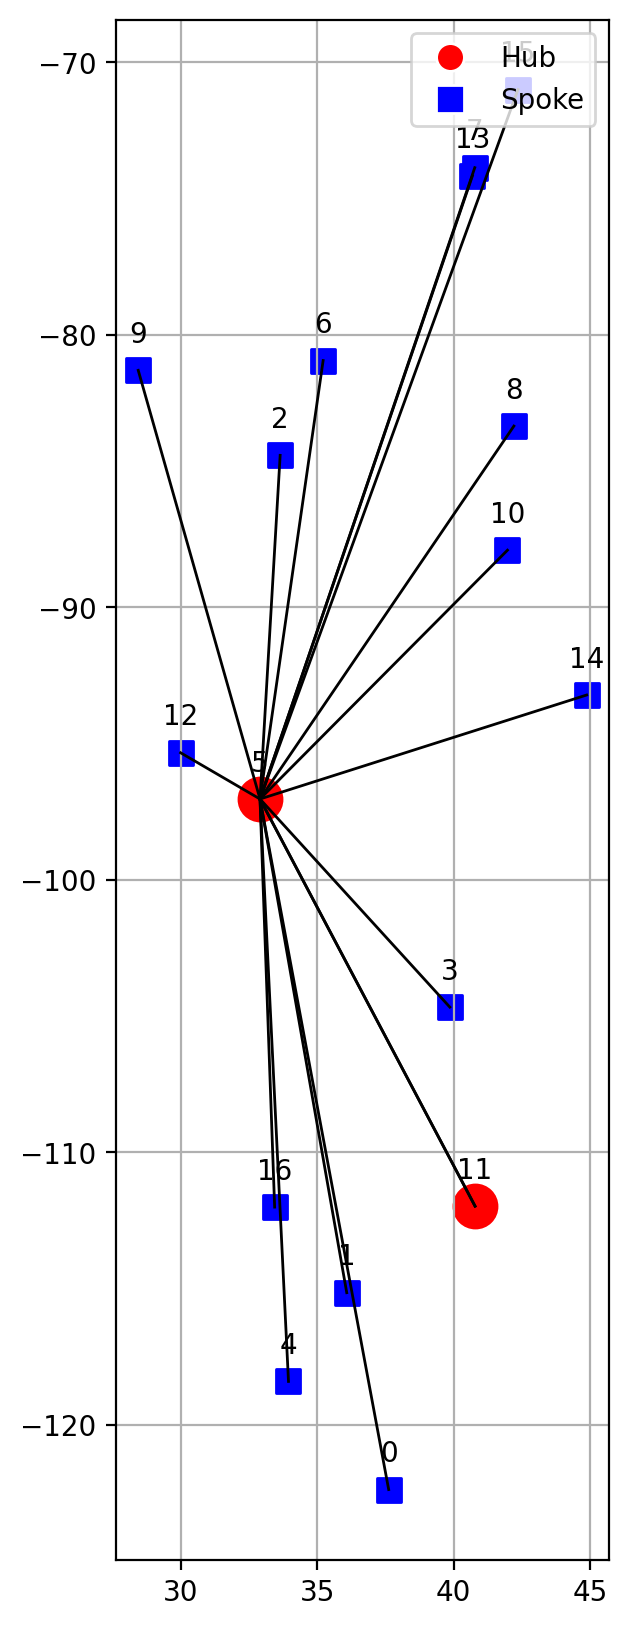

In [451]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample pandas DataFrame with coordinates, types, and IDs
df = city_small.iloc[0:N, :]
df['type'] = node_type


# Create a dictionary of symbols and colors for different node types
node_symbols = {'hub': 'o', 'spoke': 's'}
node_colors = {'hub': 'red', 'spoke': 'blue'}

# Create a list of markers and colors for each node based on its type
markers = [node_symbols[node_type] for node_type in df['type']]
colors = [node_colors[node_type] for node_type in df['type']]

# Create a list of sizes for each node based on its type
sizes = [240 if node_type == 'hub' else 80 for node_type in df['type']]

# Increase resolution and plot the nodes
plt.figure(figsize=(10, 10), dpi=200)
for i, row in df.iterrows():
    plt.scatter(row['lat'], row['lon'], c=colors[i], marker=markers[i], s=sizes[i], label=df['type'][i])

# Annotate the nodes with labels from the 'id' column
for i, label in enumerate(df['id']):
    plt.annotate(label, (df['lat'][i], df['lon'][i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add edges for connected nodes
for i in range(len(connected_matrix)):
    for j in range(len(connected_matrix[i])):
        if connected_matrix[i][j] == 1:
            plt.plot([df['lat'][i], df['lat'][j]], [df['lon'][i], df['lon'][j]], 'k-', lw=1)  # 'k-' represents black lines

# Create a legend for node types
hub_marker = plt.Line2D([0], [0], marker='o', color='w', label='Hub', markersize=10, markerfacecolor='red')
spoke_marker = plt.Line2D([0], [0], marker='s', color='w', label='Spoke', markersize=10, markerfacecolor='blue')
plt.legend(handles=[hub_marker, spoke_marker], loc='upper right')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.grid()
plt.show()


In [452]:
c_matrix = np.zeros(shape = (N, N))
node_type = ["spoke" for i in range(N)]
for i in range(N):
    for j in range(N):
        c_ij_Var = model.getVarByName("c" + str(i) +'_' + str(j))
        c_matrix[i][j] = c_ij_Var.x
        if i == j:
            if c_ij_Var.x == 1:
                node_type[i] = "hub"

In [453]:
total_distance = 0
# Create an non-linear expression for the objective
for i in range(N):
    for j in range(N):
        f_ij = package_mat[i][j]
        for k in range(N):
            cur_cVar = c_matrix[i][k]
            d_ik = distance_matrix[i][k]
            total_distance += f_ij * d_ik * cur_cVar
        for m in range(N):
            cur_cVar = c_matrix[j][m]
            d_jm = distance_matrix[j][m]
            total_distance += f_ij * d_jm * cur_cVar
        for k in range(N):
            for m in range(N):
                total_distance += f_ij * c_matrix[i][k] * c_matrix[j][m] * distance_matrix[k][m]


In [454]:
if index == 1:
    k_df = {}
k_df[K] = total_distance
k_df_df = pd.DataFrame(k_df, index = [0])
k_df_df = k_df_df.T
k_df_df["K"] = k_df_df.index

In [455]:
if index == 1:
    c_df = {}
c_df[c] = total_distance
c_df_df = pd.DataFrame(c_df, index = [0])
c_df_df = c_df_df.T
c_df_df["c"] = c_df_df.index

# Total distance

Text(0.5, 1.0, 'Total Distance ~ c')

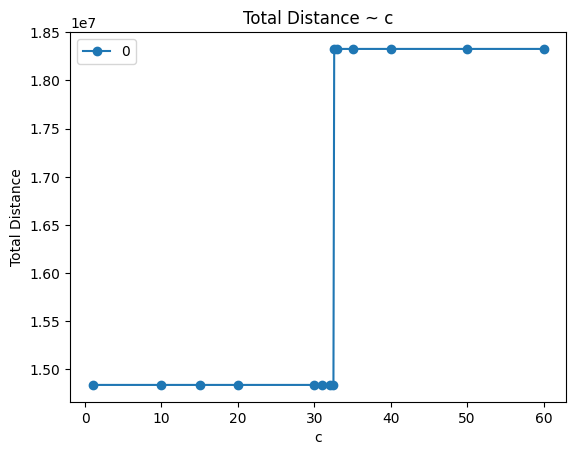

In [456]:
ax = c_df_df.sort_values("c").plot(x = "c", marker = 'o')
ax.set_xlabel("c")
ax.set_ylabel("Total Distance")
ax.set_title("Total Distance ~ c")

In [457]:
D_mat = np.ones(shape = (N, N))
for i in range(N):
    D_mat[i][i] = 0

total_overhead_cost = 0
# Create an non-linear expression for the objective
for i in range(N):
    for j in range(N):
        f_ij = package_mat[i][j]
        i_ij = 1
        for k in range(N):
            for m in range(N):
                i_ij += c_matrix[i][k] * c_matrix[j][m]* D_mat[k][m]
        total_overhead_cost += f_ij * i_ij

In [458]:
if index == 1:
    k_df_cost = {}
k_df_cost[K] = total_overhead_cost
k_df_df["overhead cost"] = 0
for i in k_df_df["K"]:
    k_df_df.loc[i, "overhead cost"] = k_df_cost[i]
k_df_df["total distance"] = k_df_df[0]

In [459]:
if index == 1:
    c_df_cost = {}
c_df_cost[c] = total_overhead_cost
c_df_df["overhead cost"] = 0
for i in c_df_df["c"]:
    c_df_df.loc[i, "overhead cost"] = c_df_cost[i]
c_df_df["total distance"] = c_df_df[0]

# Overhead cost

Text(0.5, 1.0, 'Overhead Cost ~ c')

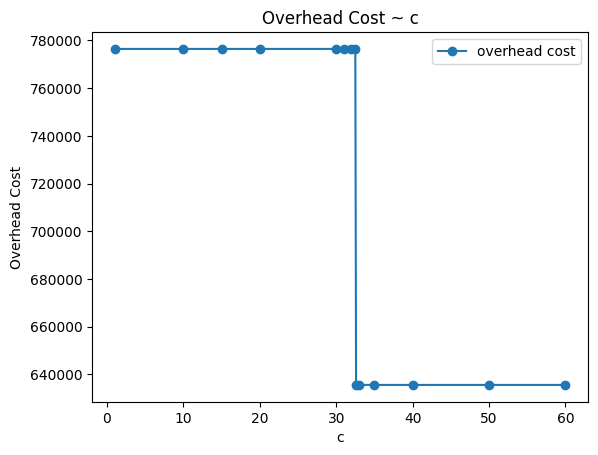

In [460]:
ax = c_df_df.sort_values("c").plot(x = "c", y = "overhead cost", marker = 'o')
ax.set_xlabel("c")
ax.set_ylabel("Overhead Cost")
ax.set_title("Overhead Cost ~ c")